## Simple text processing and gradient boosting.
This lab assigments consists of two parts:

1. Simple text classification using Bag of Words and TF-IDF.
2. Human activity classification using gradient boosting.

These tasks are independent.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Part I: Prohibited Comment Classification (2 points)
This part of assigment is fully based on YSDA NLP_course homework. Special thanks to YSDA team for making it available on github.

![img](https://github.com/yandexdataschool/nlp_course/raw/master/resources/banhammer.jpg)

__In this part__ you will build an algorithm that classifies social media comments into normal or toxic.
Like in many real-world cases, you only have a small (10^3) dataset of hand-labeled examples to work with. We'll tackle this problem using both classical nlp methods and embedding-based approach.

In [2]:
import pandas as pd
data = pd.read_csv("comments.tsv", sep='\t')

texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

should_ban                                       comment_text
50            0  "Those who're in advantageous positions are th...
250           1          Fartsalot56 says f**k you motherclucker!!
450           1  Are you a fool? \r\n\r\nI am sorry, but you se...
650           1    I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850           0  Citing sources\r\n\r\nCheck out the Wikipedia:...

In [3]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [4]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [5]:
# task: preprocess each comment in train and test
texts_train = [preprocess(text) for text in texts_train]
texts_test  = [preprocess(text) for text in texts_test]

In [6]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [7]:
# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))
    
from collections import Counter
all_comments = ''.join(texts_train).split()
#all_comments = [c for c in all_comments if len(c)>1]
cnt = Counter(all_comments)
cnt_k = dict(cnt.most_common(k))

bow_vocabulary = list(cnt_k.keys())

print('example features:', sorted(bow_vocabulary)[::100])

example features: ['!', '#irsentience', '.laara', '10:15', '28or_k', '?also', 'adequate', 'allways', 'aproaches', 'australian', 'bellamy', 'botticelli', 'campbell', 'chinelo', 'commons', 'contracted', 'cultist', 'deletions', 'direction', "duck's", 'encounter', 'exercise', 'feels', 'formally', 'gene', 'guns', 'heroes', 'huskies', 'infected', 'israelis', 'kindergarten', 'lewis', 'lowell', 'meant', 'monkeyzpop', 'negotiable', 'obama', 'outdated', 'perpetuating', 'porn', 'projects', 'races', 'regrettably', 'retentive', 'sake', 'seriously', 'singular', 'spam', 'street', 'swallow', 'than', 'toilet', 'two-liner', 'userpage', 'war"', 'wikipedia_talk', 'yellow', 'ு']


In [8]:
def text_to_bow(text):
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    res = dict.fromkeys(bow_vocabulary, 0)
    #res['UNK'] = 0
    t_list = text.split()
    for t in t_list:
        if t in bow_vocabulary:
            res[t] += 1           
    
    return np.fromiter(res.values(), 'float32')


In [9]:
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

In [10]:
# Small check that everything is done properly
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Machine learning stuff: fit, predict, evaluate. You know the drill.

In [11]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

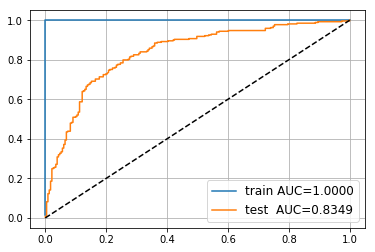

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [13]:
len(set(' '.join(texts_train).split()))

5722

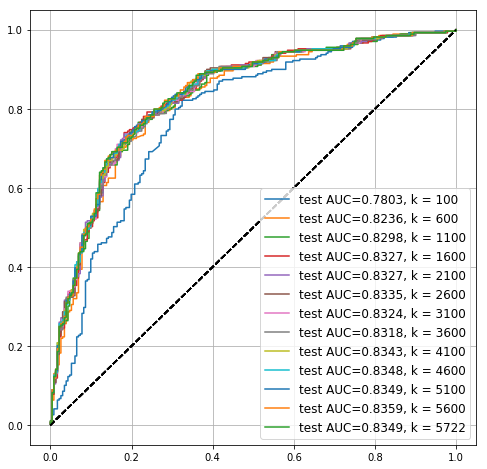

In [14]:
plt.figure(figsize = (8, 8))
auc_arr = []
k_arr = []
for k in range(100, 6600, 500):
    k = min(k, len(set(' '.join(texts_train).split())))
    all_comments = ''.join(texts_train).split()
    cnt = Counter(all_comments)
    cnt_k = dict(cnt.most_common(k))
    bow_vocabulary = list(cnt_k.keys())
    
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    
    bow_model = LogisticRegression().fit(X_train_bow, y_train)

    proba = bow_model.predict_proba(X_test_bow)[:, 1]
    auc = roc_auc_score(y_test, proba)
    auc_arr.append(auc)
    k_arr.append(k)
    plt.plot(*roc_curve(y_test, proba)[:2], label='test AUC=%.4f, k = %.0f' %(auc, k))

    plt.plot([0, 1], [0, 1], '--', color='black',)
    plt.legend(fontsize='large', loc = 'lower right')
    plt.grid()

In [15]:
auc_arr = []
k_arr = []
for k in range(100, 5900, 100):
    k = min(k, len(set(' '.join(texts_train).split())))
    all_comments = ''.join(texts_train).split()
    cnt = Counter(all_comments)
    cnt_k = dict(cnt.most_common(k))
    bow_vocabulary = list(cnt_k.keys())
    
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    
    bow_model = LogisticRegression().fit(X_train_bow, y_train)

    proba = bow_model.predict_proba(X_test_bow)[:, 1]
    auc = roc_auc_score(y_test, proba)
    auc_arr.append(auc)
    k_arr.append(k)

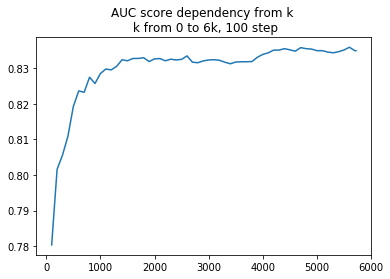

In [16]:
plt.plot(k_arr, auc_arr)
plt.title('AUC score dependency from k \n k from 0 to 6k, 100 step')
plt.show()

In [17]:
auc_arr = []
k_arr = []
for k in range(1, 201, 10):
    k = min(k, len(set(' '.join(texts_train).split())))
    all_comments = ''.join(texts_train).split()
    cnt = Counter(all_comments)
    cnt_k = dict(cnt.most_common(k))
    bow_vocabulary = list(cnt_k.keys())
    
    X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
    X_test_bow = np.stack(list(map(text_to_bow, texts_test)))
    
    bow_model = LogisticRegression().fit(X_train_bow, y_train)

    proba = bow_model.predict_proba(X_test_bow)[:, 1]
    auc = roc_auc_score(y_test, proba)
    auc_arr.append(auc)
    k_arr.append(k)

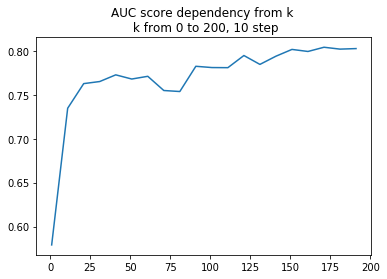

In [18]:
plt.plot(k_arr, auc_arr)
plt.title('AUC score dependency from k \n k from 0 to 200, 10 step')
plt.show()

We can see that top 1000 words give us a pretty good predicion. But 30 words already predict class quite satisfactory.

#### Task: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [19]:
from math import log

In [20]:
def get_tf(word, comment): #tf as a word frequency in one comment
    cnt = 0
    c = comment.split()
    for w in c:
        if w == word:
            cnt +=1
    return cnt/len(c)

In [21]:
def get_idf(word, text): #idf for a word in all comments as it computed in the assignment
    alpha = 1
    l = len(text)
    n = 0
    for comment in text:
        c = comment.split()
        if word in c:
            n+=1
            
    return log(l/(n+alpha))

In [22]:
def get_idf_list(features, text): #get all idfs
    idf = []
    for f in features:
        idf.append(get_idf(f, texts_train))
    return idf

In [23]:
def get_features(text): # get list of words in train dataset
    words = set()
    for t in text:
        words.update(set(t.split()))
    return words

In [24]:
def get_values(text, features): #returns tf-idf matrix
    idf = get_idf_list(features, text)
    l = len(features)
    arr = np.empty((len(text),l))
    j = 0
    for comment in text:
        a = np.empty(l)
        i = 0
        for f in features:
            a[i] = get_tf(f, comment)*idf[j]
            i += 1
        arr[j] = a
        j += 1 
    return arr

In [25]:
%%time
features = get_features(texts_train)

Wall time: 5.98 ms


In [26]:
%%time
X_train = get_values(texts_train, features)

Wall time: 26.6 s


In [27]:
%%time
X_test = get_values(texts_test, features)

Wall time: 24 s


In [28]:
%%time 
bow_model = LogisticRegression().fit(X_train, y_train)
proba = bow_model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, proba)

Wall time: 19.9 ms


In [29]:
round(auc, 4)

0.86

We got slightly beter AUC when using tf-idf, than  when using bag of words. 0.8615 vs 0.8359

### Part 2: gradient boosting (4 points)

Here we will work with widely known Human Actividy Recognition (HAR) dataset. Data is available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). Download it and place in `data/` folder in the same directory as this notebook. There are available both raw and preprocessed datasets. This time we will use the preprocessed one.

First you are required to choose one of the main gradient boosting frameworks:
1. LightGBM by Microsoft. [Link to github](https://github.com/Microsoft/LightGBM). One of the most popular frameworks these days that shows both great quality and performance.
2. xgboost by dlmc. [Link to github](https://github.com/dmlc/xgboost). The most famous framework which got very popular on kaggle.
3. Catboost by Yandex. [Link to github](https://github.com/catboost/catboost). Novel framework by Yandex company tuned to deal well with categorical features. It's quite new, but if you wish to use it - you are welcome.

Some simple preprocessing is done for you. 

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 85% accuracy on test dataset.

In [146]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [147]:
X_train = np.genfromtxt('data/train/X_train.txt')
y_train = np.genfromtxt('data/train/y_train.txt')

X_test = np.genfromtxt('data/test/X_test.txt')
y_test = np.genfromtxt('data/test/y_test.txt')

with open('data/activity_labels.txt', 'r') as iofile:
    activity_labels = iofile.readlines()

activity_labels = [x.replace('\n', '').split(' ') for x in activity_labels]
activity_labels = dict([(int(x[0]), x[1]) for x in activity_labels])

In [148]:
activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

In [149]:
print(X_train.shape)
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean)/data_std
X_test = (X_test - data_mean)/data_std

(7352, 561)


The dataset has some duplicating features. File `unique_columns.txt` stores the indices of the unique ones. 

In [150]:
unique_columns = np.genfromtxt('unique_columns.txt', delimiter=',').astype(int)
X_train_unique = X_train[:, unique_columns]
X_test_unique = X_test[:, unique_columns]

PCA could be useful in this case. E.g.

In [151]:
pca = PCA(0.99)

In [152]:
X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

In [153]:
X_train_pca.shape

(7352, 179)

In [154]:
X_test_pca.shape

(2947, 179)

Text(0,0.5,'Principal component 2')

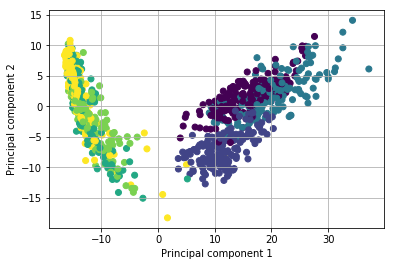

In [155]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

Text(0,0.5,'Principal component 5')

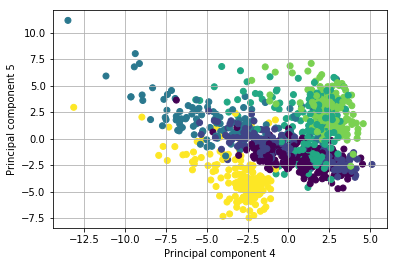

In [156]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel('Principal component 4')
plt.ylabel('Principal component 5')

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to use grid/random search (or any other approach) to approximate them by yourself.

In [157]:
# My code here.
import xgboost as xgb

In [178]:
%%time
bst = xgb.XGBClassifier(learning_rate=0.02, n_estimators=600, objective = 'multi:softprob', silent=True, nthread=1)

from sklearn.model_selection import RandomizedSearchCV
#params = {'alpha': np.linspace(0.0, 1, 11), 'gamma': np.linspace(0.0, 1000, 11),\
#    'max_depth': np.linspace(1, 100, 11),\
#    'min_child_weight': np.linspace(0.0, 1000, 11),\
#    'max_delta_step': np.linspace(0.0, 10, 11),\
#    'subsample': np.linspace(0.1, 1, 10),\
#    'num_boost_round': np.linspace(10, 510, 10)}

params = {'alpha': [ 0.1, 0.2,  0.3, 0.4, 0.5], \
          'gamma': [0,100, 200, 300, 400, 500],\
    'max_depth': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],\
    'min_child_weight': [0,100, 200, 300, 400, 500],\
    'max_delta_step': [0,1,2,3,4,5,6,7,8,9,10],\
    'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],\
    'num_boost_round': [10, 100, 200, 300, 400, 500]}

random_search = RandomizedSearchCV(bst, param_distributions=params, n_iter=5, n_jobs=-1, cv=5, random_state=42, scoring = 'accuracy' )


random_search.fit(X_test, y_test)

Wall time: 27min 22s


In [179]:
random_search.best_params_

{'subsample': 0.9,
 'num_boost_round': 400,
 'min_child_weight': 100,
 'max_depth': 90,
 'max_delta_step': 5,
 'gamma': 200,
 'alpha': 0.1}

In [196]:
bst = xgb.XGBClassifier(subsample =  0.9,
 num_boost_round = 400,
 min_child_weight=100,
 max_depth=90,
 max_delta_step=5,
 gamma=200,
 alpha= 0.1, objective = 'multi:softprob', num_class = 7)

In [197]:
%%time
bst.fit(X_train, y_train)

Wall time: 3min 40s


XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=200,
       learning_rate=0.1, max_delta_step=5, max_depth=90,
       min_child_weight=100, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_boost_round=400, num_class=7,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.9)

In [198]:
y_pred = bst.predict(X_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [200]:
from sklearn.metrics import accuracy_score
round(accuracy_score(y_test, y_pred), 2)

0.88